In [14]:
from IPython import display

from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from utils import Logger

import tensorflow as tf

import numpy as np

ImportError: cannot import name 'Logger'

In [ ]:
!pip uninstall utils

In [ ]:
!pip install utils

In [3]:
DATA_FOLDER = './tf_data/VGAN/MNIST'
IMAGE_PIXELS = 28*28
NOISE_SIZE = 100
BATCH_SIZE = 100

In [4]:
def noise(n_rows, n_cols):
    return np.random.normal(size=(n_rows, n_cols))

def xavier_init(size):
    in_dim = size[0] if len(size) == 1 else size[1]
    stddev = 1. / np.sqrt(float(in_dim))
    return tf.random_uniform(shape=size, minval=-stddev, maxval=stddev)

def images_to_vectors(images):
    return images.reshape(images.shape[0], 784)

def vectors_to_images(vectors):
    return vectors.reshape(vectors.shape[0], 28, 28, 1)

## Load Data

In [5]:
def mnist_data():
    compose =  transforms.Compose([
transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

In [6]:
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
# Num batches
num_batches = len(data_loader)

 99%|█████████▉| 9854976/9912422 [00:35<00:00, 570771.13it/s]

Extracting ./tf_data/VGAN/MNIST/dataset\MNIST\raw\train-images-idx3-ubyte.gz to ./tf_data/VGAN/MNIST/dataset\MNIST\raw



0it [00:00, ?it/s]
 57%|█████▋    | 16384/28881 [00:01<00:00, 44722.68it/s]
32768it [00:01, 28710.03it/s]                           

Extracting ./tf_data/VGAN/MNIST/dataset\MNIST\raw\train-labels-idx1-ubyte.gz to ./tf_data/VGAN/MNIST/dataset\MNIST\raw



0it [00:00, ?it/s]
 97%|█████████▋| 1605632/1648877 [00:04<00:00, 534733.42it/s]

Extracting ./tf_data/VGAN/MNIST/dataset\MNIST\raw\t10k-images-idx3-ubyte.gz to ./tf_data/VGAN/MNIST/dataset\MNIST\raw




0it [00:00, ?it/s]

  0%|          | 0/4542 [00:00<?, ?it/s]

8192it [00:00, 11343.97it/s]            

Extracting ./tf_data/VGAN/MNIST/dataset\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./tf_data/VGAN/MNIST/dataset\MNIST\raw
Processing...
Done!


## Initialize Graph

In [7]:
## Discriminator

# Input
X = tf.placeholder(tf.float32, shape=(None, IMAGE_PIXELS))

# Layer 1 Variables
D_W1 = tf.Variable(xavier_init([784, 1024]))
D_B1 = tf.Variable(xavier_init([1024]))

# Layer 2 Variables
D_W2 = tf.Variable(xavier_init([1024, 512]))
D_B2 = tf.Variable(xavier_init([512]))

# Layer 3 Variables
D_W3 = tf.Variable(xavier_init([512, 256]))
D_B3 = tf.Variable(xavier_init([256]))

# Out Layer Variables
D_W4 = tf.Variable(xavier_init([256, 1]))
D_B4 = tf.Variable(xavier_init([1]))

# Store Variables in list
D_var_list = [D_W1, D_B1, D_W2, D_B2, D_W3, D_B3, D_W4, D_B4]

In [8]:
## Generator

# Input
Z = tf.placeholder(tf.float32, shape=(None, NOISE_SIZE))

# Layer 1 Variables
G_W1 = tf.Variable(xavier_init([100, 256]))
G_B1 = tf.Variable(xavier_init([256]))

# Layer 2 Variables
G_W2 = tf.Variable(xavier_init([256, 512]))
G_B2 = tf.Variable(xavier_init([512]))

# Layer 3 Variables
G_W3 = tf.Variable(xavier_init([512, 1024]))
G_B3 = tf.Variable(xavier_init([1024]))

# Out Layer Variables
G_W4 = tf.Variable(xavier_init([1024, 784]))
G_B4 = tf.Variable(xavier_init([784]))

# Store Variables in list
G_var_list = [G_W1, G_B1, G_W2, G_B2, G_W3, G_B3, G_W4, G_B4]

In [9]:
def discriminator(x):
    l1 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(x,   D_W1) + D_B1, .2), .3)
    l2 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(l1,  D_W2) + D_B2, .2), .3)
    l3 = tf.nn.dropout(tf.nn.leaky_relu(tf.matmul(l2,  D_W3) + D_B3, .2), .3)
    out = tf.matmul(l3, D_W4) + D_B4
    return out

def generator(z):
    l1 = tf.nn.leaky_relu(tf.matmul(z,  G_W1) + G_B1, .2)
    l2 = tf.nn.leaky_relu(tf.matmul(l1, G_W2) + G_B2, .2)
    l3 = tf.nn.leaky_relu(tf.matmul(l2, G_W3) + G_B3, .2)
    out = tf.nn.tanh(tf.matmul(l3, G_W4) + G_B4)
    return out

In [10]:
G_sample = generator(Z)
D_real = discriminator(X)
D_fake = discriminator(G_sample)

# Losses
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real, labels=tf.ones_like(D_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.zeros_like(D_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake, labels=tf.ones_like(D_fake)))

# Optimizers
D_opt = tf.train.AdamOptimizer(2e-4).minimize(D_loss, var_list=D_var_list)
G_opt = tf.train.AdamOptimizer(2e-4).minimize(G_loss, var_list=G_var_list)

W0906 19:33:55.875345  5788 deprecation.py:506] From <ipython-input-9-30143257e23a>:2: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0906 19:33:55.887321  5788 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0906 19:33:55.947302  5788 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0906 19:33:55.971306  5788 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0906 19:33:55.995299  5788 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead

## Train

#### Testing

In [11]:
num_test_samples = 16
test_noise = noise(num_test_samples, NOISE_SIZE)

#### Inits

In [12]:
num_epochs = 200

# Start interactive session
session = tf.InteractiveSession()
# Init Variables
tf.global_variables_initializer().run()
# Init Logger
logger = Logger(model_name='DCGAN1', data_name='CIFAR10')

NameError: name 'Logger' is not defined

9920512it [00:50, 570771.13it/s]                             
1654784it [00:21, 534733.42it/s]                             

#### Train

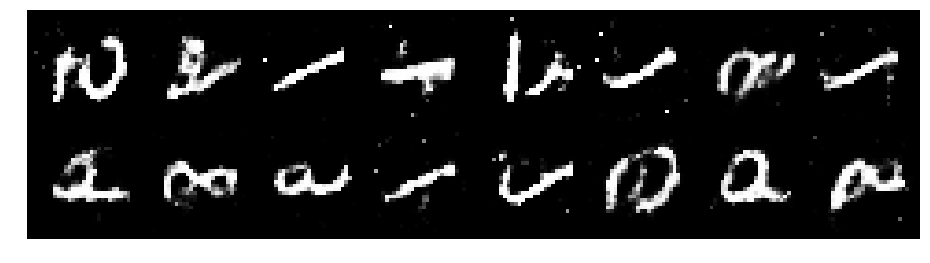

Epoch: [121/200], Batch Num: [400/600]
Discriminator Loss: 1.3490, Generator Loss: 0.8427
D(x): -0.0159, D(G(z)): -0.2178


In [ ]:
# Iterate through epochs
for epoch in range(num_epochs):
    for n_batch, (batch,_) in enumerate(data_loader):
        
        # 1. Train Discriminator
        X_batch = images_to_vectors(batch.permute(0, 2, 3, 1).numpy())
        feed_dict = {X: X_batch, Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, d_error, d_pred_real, d_pred_fake = session.run(
            [D_opt, D_loss, D_real, D_fake], feed_dict=feed_dict
        )

        # 2. Train Generator
        feed_dict = {Z: noise(BATCH_SIZE, NOISE_SIZE)}
        _, g_error = session.run(
            [G_opt, G_loss], feed_dict=feed_dict
        )

        if n_batch % 100 == 0:
            display.clear_output(True)
            # Generate images from test noise
            test_images = session.run(
                G_sample, feed_dict={Z: test_noise}
            )
            test_images = vectors_to_images(test_images)
            # Log Images
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches, format='NHWC');
            # Log Status
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )